# Titanic Passanger Survival Prediction

This notebook contains my efforts and thoughts for the Titanic: Machine Learning from Disaster [Kaggle](https://www.kaggle.com/c/titanic) competition. The aim is to explore different machine learning concepts rather than to find the optimal score. It is also a practice in making a well documented and easy to follow notebook.

### Covered topics
- Data preprocessing using Pandas
- Feature engineering
- Conventional ML models using scikit-learn
- Ensambles
- Hyperparameter tuning
- Neural network model using Tensorflow

### Things for another day
- Visualizations
- Regularization
- Error Analysis

In [90]:
# Library imports
import math
from time import time
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
import pandas as pd
import sklearn as sk
import sklearn.ensemble as ske
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [91]:
# Removes a warning in sklearn that will be fixed during an update mid 2018
import warnings

if __name__ == '__main__':
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    le = sk.preprocessing.LabelEncoder()
    le.fit([1, 2, 2, 6])
    le.transform([1, 1, 2, 6])
    le.inverse_transform([0, 0, 1, 2])

## Reading the data
We will use widely used [Pandas](https://pandas.pydata.org/) to preprocess our data. We start with reading the data from .csv with read_csv(). When we have our dataframe in memory we can use head to take a first look at our data. 

In [92]:
df = pd.read_csv('C:/GitHub/kaggle/titanic/data/train.csv', sep=',', header=0)
print('Data size: ' + str(df.shape))
df.head(5)

Data size: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Analysing the data
Now we can inspect our features. We have 11 feauters, which we will call X, and 1 output (Survived), which we will call y. We can also see that we have 891 training examples. Now let's go over our features and try to reason over them. The most important thing is to find data that we think might affect the chance of survival for a passenger.

#### PassangerId
This is just used for indentification when scoring the predictions. It does not contain any ground truth about passengers and their survival and should therefore be removed before training.

#### Survived
This is what we want to predict, our output y. It should be split from the features and kept separate.

#### Pclass
The fare class of the passenger. Pclass = 1 is first class, Pclass = 2 is second class and Pclass = 3 is third class. This feature will likely affect survival. Things such people density and the distribution of [life boats](https://en.wikipedia.org/wiki/Lifeboats_of_the_RMS_Titanic) will likely vary amoung classes and play a part in survival.

#### Name
There are two things with the name that might be interesting in terms of surivival. The name might give us the gender of the passenger. We can however see that the gender is already provided in another feature, so there is no point in extracting it here. The second, and more interesting thing, is the title. The title can tell us the marital and sociatal status of a passenger.

#### Sex
["Women and children first"](https://en.wikipedia.org/wiki/Women_and_children_first) is famously associated with the Titanic. Therefore it is safe to assume that sex will play a large factor in survival.

#### Age
The same motivation as with sex can be applied as to why age would be important for survival.

#### SibSp
Number of siblings/spouses onboard. Probably will be a factor for survival since family members can help eachother.

#### Parch
Number of parents/children onboard. Very similar to the feature above.

#### Ticket
The tickets numbers seem to have some useful information in them. However, there seem to be little structure in the data. I decided to skip it to minimize initial effort. Might revise it later.

#### Fare
The price of the ticket. Will likely have similar factors as Pclass.

#### Embarked
Port of embarkation. Where C = Cherbourg, Q = Queenstown and S = Southampton. This should, at first glance, not play a big role in survival. However, it could possibly be a indirect factor and should not be dismissed without investigation.

### Data size
891 samples of data is on the low end for machine learning. It will mean that the model might be subseptible to overfitting. Overfitting is when to model specializes too much on the given dataset instead of learning a ground truth which that can help with predicting previously unseen data. It also means that it might be reasonable to chose simpler, conventional, machine learning models instead of the more data hungry neural networks.

# Utils
Below is just some util functions that will later be used for feature engineering

In [93]:
# Checks and returns if a string contains one of a list of given substrings.
def substrings_in_string(whole, subs): 
    
    for x in subs:
        if x in str(whole): 
            return x
        
    return 'Unknown'

In [94]:
# Extract title from a name
def extract_title(full_name):
    
    full_name  = str(full_name)
    
    x = full_name.split(", ")
    x = x[1]
    x = x.split('.')
    title = x[0]
    
    return title

In [95]:
# Simplify titles into fewer more significant titles
def simplify_titles(x):
    
    title=x['Title']
    
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', 'Sir']:
        return 'Mr'
    elif title in ['the Countess', 'Mme', 'Dona', 'Lady']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title == 'Dr':
        if x['Sex'] == 0:
            return 'Mrs'
        else:
            return 'Mr'
    else:
        return title
    

## Data preprocessing and feature engineering
Data preprocessing and feature engineering go hand in hand and have the aim find the best possible data for a model. They are together probably the most important part for the success of a model, especially when the data size is small.

### Data preprocessing
Data preprocessing is when data is made adjusted to be recieved by a model. The following processing is performed:
- Removing noise - Data not relevant for the prediction will make the model more noisy and should be removed.
- Missing values - Values that are missing are filled with mean of most common occuring value.
- Normalization - If data on different scales will serve as initial weights for the model. Therefor it is good to normalize the data and let the model find the weights be itself. A good normalization is to have all data on a magnititude of 0.0 - 1.0.
- Data discretation - Data that represents different categories (such as Pclass) can be represented as separate discreet features instead of quanties.

### Feature engineering
Feature engineering is when domain knowledge is applied to find new features that will be more useful for the model. The following techniques were used.
- Indicator Variables - Quantities can be divided into meaningful brackets. Example: Age can be divided into categories to find children since we know that they are more likely to live.
- Interaction Features - Features can sometimes be combined into something meaningful. Example: SibSp and Parch can be combined to find the family size.
- Grouping sparse data - Categorical data that has low occurence can be grouped into larger meaningful categories.


In [96]:
def preprocess_dataframe(df, prediction_data=False, print_info=False):
    # Age has missing values which is replaced with average
    # Might also consider dividing age into classes of age brackets
    df['Age'].fillna((df['Age'].mean()), inplace = True)
    df['Fare'].fillna((df['Fare'].mean()), inplace = True)
    
    # Encode sex into binary (0 = male, 1 = female)
    df['Sex'] = df['Sex'].map({'female': 1, 'male': 0})
    
    # Use the prefix in cabin to find the deck of the cabin
    cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
    df['Deck' ]= df['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))
    
    # Calculate family size by combining SibSp and Parch
    df['FamilySize'] = df['SibSp'] + df['Parch']
    
    # Divide age into useful brackets
    df['Child'] = df['Age'].apply(lambda x: 1 if x <= 12 else 0)

    """
    # Extract and process titles
    df['Title']= df['Name'].map(lambda x: extract_title(x))
    if not prediction_data:
        unique_titles = df['Title'].unique()
        survival_by_title = df.groupby('Title').mean()['Survived']
        
    df['Title']=df.apply(simplify_titles, axis=1)
    if not prediction_data:
        unique_titles_simplified = df['Title'].unique()
        survival_by_title_simplified = df.groupby('Title').mean()['Survived']
    """
    

    # Gather info on the significance of these classes for survival
    # Class was, as expected, significance for surival with the rates (1st - 63%, 2nd - 47%, 3rd - 24%)
    # Embarked was suprisingly significant, C - Cherbourg had 55% surivial rate when the mean was just 38%
    if not prediction_data:
        survival_by_plcass = df.groupby('Pclass').mean()['Survived']
        survival_by_deck = df.groupby('Deck').mean()['Survived']
        survival_by_embark = df.groupby('Embarked').mean()['Survived']
        survival_by_familysize = df.groupby('FamilySize').mean()['Survived']
        survival_by_child = df.groupby('Child').mean()['Survived']
    
    # Split classes with one hot encoding
    # Pclass   - splits into (1 = Pclass_1, 2 = Pclass_2, 3 = Pclass_3)
    # Embarked - splits into (C = Embarked_C, Q = Embarked_Q, S = Embarked_S)
    # Deck - splits into decks with letters
    df = pd.get_dummies(df, columns = ['Pclass', 'Embarked', 'Deck']) #, 'Title'])

    # Drop columns with data deemed not relevant for learning
    # Name     - Gender already has its' own column. Only thing that might be interesting here is the title
    # Ticket   - Ticket does not really say much, price and class are already included which says the most
    # Cabin    - Replaced by Deck
    df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Age', 'SibSp', 'Parch'], axis=1)
    
    # Deck_T is not present in the train set and must be inserted for uniformity
    if prediction_data:
        m = df.shape[0]
        df['Deck_T'] = pd.Series(np.zeros(m, dtype=int), index=df.index)
    
    # Normalize the data
    norm_vals = ['Fare', 'FamilySize']
    df[norm_vals] = (df[norm_vals] - df[norm_vals].min())/(df[norm_vals].max() - df[norm_vals].min())
    
    # Look at interesting metrics to find information about the preprocessing/feature engineering
    if print_info:
        if not prediction_data:
            print('--------------------------------------------------------------------------------------')
            print('SURVIVAL RATE')
            print('--------------------------------------------------------------------------------------')
            print('Overall survival rate: ' + str(df['Survived'].mean()))
            print()
            print(survival_by_plcass)
            print()
            print(survival_by_embark)
            print()
            print(survival_by_deck)
            print()
            """
            print(survival_by_title)
            print()
            print(survival_by_title_simplified)
            print()
            """
            print(survival_by_familysize)
            print()
            print(survival_by_child)
        """
        print('--------------------------------------------------------------------------------------')
        print('TITLES')
        print('--------------------------------------------------------------------------------------')
        print('All titels: ')
        print(unique_titles)
        print()
        print('Simplied titels: ')
        print(unique_titles_simplified)
        """
        print('--------------------------------------------------------------------------------------')
        print('SUMS')
        print('--------------------------------------------------------------------------------------')
        print(df.sum())
        print('--------------------------------------------------------------------------------------')
        print('DATA INFO')
        print('--------------------------------------------------------------------------------------')
        print(df.info())
        print('--------------------------------------------------------------------------------------')
        print('MISSING VALUES')
        print('--------------------------------------------------------------------------------------')
        print(df.isnull().sum())
        print('--------------------------------------------------------------------------------------')
        print('CORRELATIONS')
        print('--------------------------------------------------------------------------------------')
        print(df.corr())
        print('--------------------------------------------------------------------------------------')

    return df

## Model validation
To score the model it is important that the scoring is not performed on data that also has been used to train the model. Otherwise the evaluation will be overly optimistic but the performance on independant data will most likely perform much worse. The solution is to exclude a fraction of the data during training so that it can later be used for evaluation. This set is usually called the cross validation set.

Validation does however don't stop after training. And every time data has been used to make a decision then new data has to be used to evaluate how well that decision will hold up on new data. A best practice is to further divide the data into train/test/cross validation.

- Train set - Data used to train the model
- Cross validation - Data used for finding deciding between different models and hyperparamteres
- Test - Data used to make a final evaluation on how the model will perform on unseen data

In this competition the test set is already set aside by default, so only a simply train/validation split is performed.  

In [97]:
# Split data into train/validation set
def split_data(df):
    df_train = df.sample(frac = 0.8, random_state = 42)
    df_val = df.drop(df_train.index)  
    
    X_train = df_train.drop(['Survived'], axis=1).values
    y_train = df_train['Survived'].values
    
    X_val = df_val.drop(['Survived'], axis=1).values
    y_val = df_val['Survived'].values
    
    return X_train, y_train, X_val, y_val

In [98]:
df_processed = preprocess_dataframe(df, False, True)

X_train, y_train, X_val, y_val = split_data(df_processed)

print ("X_train shape: " + str(X_train.shape))
print ("y_train shape: " + str(y_train.shape))
print ("X_val shape: " + str(X_test.shape))
print ("y_val shape: " + str(y_test.shape))

df_processed.head(5)

--------------------------------------------------------------------------------------
SURVIVAL RATE
--------------------------------------------------------------------------------------
Overall survival rate: 0.3838383838383838

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

Deck
A          0.466667
B          0.744681
C          0.593220
D          0.757576
E          0.757576
F          0.583333
G          0.500000
T          0.000000
Unknown    0.299854
Name: Survived, dtype: float64

FamilySize
0     0.303538
1     0.552795
2     0.578431
3     0.724138
4     0.200000
5     0.136364
6     0.333333
7     0.000000
10    0.000000
Name: Survived, dtype: float64

Child
0    0.367397
1    0.579710
Name: Survived, dtype: float64
--------------------------------------------------------------------------------------
SUMS
-----------------------------------------------------

,Survived,Sex,Fare,FamilySize,Child,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Unknown
0,0,0,0.014151,0.1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
1,1,1,0.139136,0.1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,1,1,0.015469,0.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
3,1,1,0.103644,0.1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,0,0,0.015713,0.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1


In [99]:
def decision_tree_clf(X_train, y_train, X_val, y_val):
    
    dt_clf = sk.tree.DecisionTreeClassifier(max_depth=20)
    dt_clf.fit (X_train, y_train)
    print(dt_clf.score (X_val, y_val))
    
    return dt_clf

In [100]:
dt_clf = decision_tree_clf(X_train, y_train, X_val, y_val)

0.8089887640449438


In [101]:
def random_forest_clf(X_train, y_train, X_test, y_test):

    rf_clf = ske.RandomForestClassifier(n_estimators=50)
    rf_clf.fit (X_train, y_train)
    print(rf_clf.score (X_test, y_test))
    
    return rf_clf

In [102]:
rf_clf = random_forest_clf(X_train, y_train, X_val, y_val)

0.8202247191011236


In [107]:
def gradient_boosting_clf(X_train, y_train, X_val, y_val):
    
    gb_clf = ske.GradientBoostingClassifier(n_estimators=50)
    gb_clf.fit (X_train, y_train)
    print(gb_clf.score (X_val, y_val))
    
    return gb_clf

In [108]:
gb_clf = gradient_boosting_clf(X_train, y_train, X_val, y_val) 

0.8314606741573034


In [109]:
def logistic_regression_clf(X_train, y_train, X_val, y_val):
    
    lr_clf = LogisticRegression()
    lr_clf.fit (X_train, y_train)
    print(lr_clf.score (X_val, y_val))
    
    return lr_clf

In [110]:
lr_clf = logistic_regression_clf(X_train, y_train, X_val, y_val)

0.8314606741573034


In [105]:
def support_vector_machine_clf(X_train, y_train, X_val, y_val):
    """
    Description:
    Builds and trains a support vector machine classifier

    Arguments:
    X_train -- Training features,numpy matrix (m, 11)
    y_train -- Training features,numpy matrix (m, )
    X_test -- Test features,numpy matrix (m, 11)
    y_test -- Test features,numpy matrix (m, )
        
    Returns:
    svm_clf -- Classifier, sklearn SVC
    """
    
    svm_clf = sk.svm.SVC(probability=True)
    svm_clf.fit (X_train, y_train)
    print(svm_clf.score (X_val, y_val))
    
    return svm_clf

In [106]:
svm_clf = support_vector_machine_clf(X_train, y_train, X_val, y_val) 

0.8089887640449438


In [65]:
def naive_bayes_clf(X_train, y_train, X_val, y_val):
    """
    Description:
    Builds and trains a gaussian naive bayes classifier

    Arguments:
    X_train -- Training features,numpy matrix (m, 11)
    y_train -- Training features,numpy matrix (m, )
    X_test -- Test features,numpy matrix (m, 11)
    y_test -- Test features,numpy matrix (m, )
        
    Returns:
    svm_clf -- Classifier, sklearn GaussianNB
    """
    
    nb_clf = GaussianNB()
    nb_clf.fit (X_train, y_train)
    print(nb_clf.score (X_val, y_val))
    
    return nb_clf

In [66]:
nb_clf = naive_bayes_clf(X_train, y_train, X_val, y_val)

0.7191011235955056


In [111]:
def k_neighbors_clf(X_train, y_train, X_val, y_val):
    """
    Description:
    Builds and trains a k-nearest neighbors classifier

    Arguments:
    X_train -- Training features,numpy matrix (m, 11)
    y_train -- Training features,numpy matrix (m, )
    X_test -- Test features,numpy matrix (m, 11)
    y_test -- Test features,numpy matrix (m, )
        
    Returns:
    svm_clf -- Classifier, sklearn KNeighborsClassifier
    """
    
    knn_clf = KNeighborsClassifier(n_neighbors=6)
    knn_clf.fit (X_train, y_train)
    print(knn_clf.score (X_val, y_val))
    
    return knn_clf

In [112]:
knn_clf = k_neighbors_clf(X_train, y_train, X_val, y_val)

0.8595505617977528


In [69]:
def ensamble_voting_clf(clfs, X_train, y_train, X_val, y_val, cv=20, score_individually=False):
    """
    Description:
    Builds and trains an ensamble of classifiers which them vote together

    Arguments:
    clfs -- Classifiers with labels, List Tuple(String, clf)
    
    Returns:
    e_clf -- Classifier, sklearn VotingClassifier
    """
    
    e_clf = ske.VotingClassifier(estimators=clfs, voting='hard') # Hard voting where majority rules
    e_clf.fit (X_train, y_train)
    
    if score_individually:
        for label, clf in clfs:
            scores = cross_val_score(clf, X_val, y_val, cv=cv, scoring='accuracy')
            print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))    
    
    scores = cross_val_score(e_clf, X_val, y_test, cv=cv, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'Voting Ensamble')) 
    
    return e_clf    

In [70]:
clfs = ([('Decision Tree', dt_clf), ('Random Forest', rf_clf), ('Gradiant Boosting', gb_clf), 
         ('Logistic Regression', lr_clf), ('SVM', svm_clf), ('Naive Bayes', nb_clf), ('K-Nearest', knn_clf)])

e_clf = ensamble_voting_clf(clfs, X_train, y_train, X_test, y_test, score_individually=True)

Accuracy: 0.80 (+/- 0.11) [Decision Tree]
Accuracy: 0.83 (+/- 0.10) [Random Forest]
Accuracy: 0.80 (+/- 0.10) [Gradiant Boosting]
Accuracy: 0.83 (+/- 0.12) [Logistic Regression]
Accuracy: 0.81 (+/- 0.10) [SVM]
Accuracy: 0.55 (+/- 0.17) [Naive Bayes]
Accuracy: 0.81 (+/- 0.11) [K-Nearest]
Accuracy: 0.86 (+/- 0.09) [Voting Ensamble]


In [72]:
def predict(df, clf, export_path):
    """
    Description:
    Makes predictions X -> y and exports to csv

    Arguments:
    df -- Data to predict from, pandas DataFrame
    clf -- classifier, Classifier, sklearn classifier object
    export_path -- Path and name of file, String
        
    Returns:
    df_pred -- prediction, pandas DataFrame
    """
    
    # Extract Ids
    y1 = df['PassengerId'].values
    
    # Make predictions
    df_process = preprocess_dataframe(df, prediction_data=True, print_info=False) 
    X = df_process.values
    y2 = clf.predict(X)
    
    # Combine ids and predictions
    y = np.column_stack((y1, y2))
    
    # Restore pandas df
    df_pred = pd.DataFrame(y)
    df_pred.columns = ["PassengerId", "Survived"]
    
    # Export
    df_pred.to_csv(export_path, sep=',', index=False)
    
    return df_pred

In [73]:
df_pred = pd.read_csv('C:/GitHub/kaggle/titanic/data/test.csv', sep=',', header=0)
df_pred = predict(df_pred, svm_clf, 'C:/GitHub/kaggle/titanic/predictions/predictions_svm.csv')
df_pred.head(5)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [74]:
def report(results, n_top=1):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [75]:
def random_search_hyperparameters(clf, hyper_param, X_train, y_train, X_test, y_test, print_result=False):
    
    # run randomized search
    n_iter_search = 10
    rnd_clf = RandomizedSearchCV(clf, param_distributions=hyper_param, n_iter=n_iter_search)

    start = time()
    rnd_clf.fit(X_train, y_train)
    
    if print_result:
        print("RandomizedSearchCV took %.2f seconds for %d candidates"
              " parameter settings." % ((time() - start), n_iter_search))
        report(rnd_clf.cv_results_)
        y_true, y_pred = y_test, clf.predict(X_test)
        scores = cross_val_score(clf, X_test, y_test, cv=20, scoring='accuracy')
        print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
        print()
        print(classification_report(y_true, y_pred))
       
    return rnd_clf  

In [76]:
def grid_search_hyperparameters(clf, hyper_param, X_train, y_train, X_test, y_test, print_result=False):
    
    # run grid search
    grid_clf = GridSearchCV(clf, param_grid=hyper_param)
    start = time()
    grid_clf.fit(X_train, y_train)
    
    if print_result:
        report(grid_clf.cv_results_)
        y_true, y_pred = y_test, clf.predict(X_test)
        scores = cross_val_score(clf, X_test, y_test, cv=20, scoring='accuracy')
        print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
        print()
        print(classification_report(y_true, y_pred))
    
    return grid_clf  

In [153]:
# specify parameters and distributions to sample from
hyper_param = {"max_depth": [3, None],
               "max_features": stats.randint(3, X_train.shape[1]),
               "min_samples_split": stats.randint(2, 11),
               "min_samples_leaf": stats.randint(1, 11),
               "bootstrap": [True, False],
               "criterion": ["gini", "entropy"]}

rf_rnd_clf = random_search_hyperparameters(rf_clf, hyper_param, X_train, y_train, X_test, y_test)

In [79]:
# use a full grid over all parameters
hyper_param = {"max_depth": [3, None],
               "max_features": [3, 10, X_train.shape[1]],
               "min_samples_split": [2, 3, 10],
               "min_samples_leaf": [1, 3, 10],
               "bootstrap": [True, False],
               "criterion": ["gini", "entropy"]}

rf_grid_clf = grid_search_hyperparameters(rf_clf, hyper_param, X_train, y_train, X_test, y_test, True)

Model with rank: 1
Mean validation score: 0.823 (std: 0.009)
Parameters: {'min_samples_split': 10, 'max_depth': 3, 'criterion': 'gini', 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 19}

Model with rank: 1
Mean validation score: 0.823 (std: 0.013)
Parameters: {'min_samples_split': 3, 'max_depth': None, 'criterion': 'entropy', 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 19}

Accuracy: 0.83 (+/- 0.11)

             precision    recall  f1-score   support

          0       0.87      0.86      0.86       113
          1       0.76      0.77      0.76        65

avg / total       0.83      0.83      0.83       178



In [155]:
# specify parameters and distributions to sample from
hyper_param = {'C': stats.randint(10, 10000),
               'gamma' : stats.uniform(0.001, 1),
               'kernel': ['rbf']}

svm_rnd_clf = random_search_hyperparameters(svm_clf, hyper_param, X_train, y_train, X_test, y_test)

In [77]:
# use a full grid over all parameters
hyper_param = {'C': [10, 100, 1000, 10000], 
               'gamma' : [0.001, 0.01, 0.1, 1], 
               'kernel': ['rbf']}

svm_grid_clf = grid_search_hyperparameters(svm_clf, hyper_param, X_train, y_train, X_test, y_test, True)

Model with rank: 1
Mean validation score: 0.813 (std: 0.009)
Parameters: {'gamma': 0.1, 'C': 10, 'kernel': 'rbf'}

Accuracy: 0.81 (+/- 0.10)

             precision    recall  f1-score   support

          0       0.84      0.87      0.85       113
          1       0.75      0.71      0.73        65

avg / total       0.81      0.81      0.81       178



In [157]:
# specify parameters and distributions to sample from
hyper_param = {'penalty': ['l1','l2'], 
               'C': stats.uniform(0.001,1000)}

lr_rnd_clf = random_search_hyperparameters(lr_clf, hyper_param, X_train, y_train, X_test, y_test)

In [158]:
# use a full grid over all parameters
hyper_param = {'penalty': ['l1','l2'], 
               'C': [0.001,0.01,0.1,1,10,100,1000]}

lr_grid_clf = grid_search_hyperparameters(lr_clf, hyper_param, X_train, y_train, X_test, y_test, True)

Model with rank: 1
Mean validation score: 0.799 (std: 0.012)
Parameters: {'C': 0.1, 'penalty': 'l2'}

Accuracy: 0.84 (+/- 0.11)

             precision    recall  f1-score   support

          0       0.87      0.85      0.86       113
          1       0.75      0.78      0.77        65

avg / total       0.83      0.83      0.83       178



In [159]:
clfs = ([('Grid Random Forest', rf_grid_clf), ('Grid SVM', svm_grid_clf), ('Grid Logistic Regression', lr_grid_clf)])

e_grid_clf = ensamble_voting_clf(clfs, X_train, y_train, X_test, y_test, score_individually=False, cv=5)

Accuracy: 0.80 (+/- 0.07) [Voting Ensamble]


In [176]:
rf_hyper_param = {"max_depth": [3, None],
                  "max_features": [3, 10, X_train.shape[1]],
                  "min_samples_split": [2, 3, 10],
                  "min_samples_leaf": [1, 3, 10],
                  "bootstrap": [True, False],
                  "criterion": ["gini", "entropy"]}

svm_hyper_param = {'C': [10, 100, 1000, 10000], 
                   'gamma' : [0.001, 0.01, 0.1, 1], 
                   'kernel': ['rbf']}

rf_grid_clf_1 = grid_search_hyperparameters(rf_clf, rf_hyper_param, X_train, y_train, X_test, y_test)
rf_grid_clf_2 = grid_search_hyperparameters(rf_clf, rf_hyper_param, X_train, y_train, X_test, y_test)
rf_grid_clf_3 = grid_search_hyperparameters(rf_clf, rf_hyper_param, X_train, y_train, X_test, y_test)

svm_grid_clf_1 = grid_search_hyperparameters(svm_clf, svm_hyper_param, X_train, y_train, X_test, y_test)
svm_grid_clf_2 = grid_search_hyperparameters(svm_clf, svm_hyper_param, X_train, y_train, X_test, y_test)
svm_grid_clf_3 = grid_search_hyperparameters(svm_clf, svm_hyper_param, X_train, y_train, X_test, y_test)

clfs = ([('RF 1', rf_grid_clf_1), 
         ('RF 2', rf_grid_clf_2), 
         ('RF 3', rf_grid_clf_3), 
         ('SVM 1', svm_grid_clf_1), 
         ('SVM 2', svm_grid_clf_2), 
         ('SVM 3', svm_grid_clf_3)])

e_grid_clf = ensamble_voting_clf(clfs, X_train, y_train, X_test, y_test, score_individually=False, cv=3)

Accuracy: 0.78 (+/- 0.02) [Voting Ensamble]


In [80]:
df_pred = pd.read_csv('C:/GitHub/kaggle/titanic/data/test.csv', sep=',', header=0)
df_pred = predict(df_pred, rf_grid_clf, 'C:/GitHub/kaggle/titanic/predictions/predictions_tuned_random_forest.csv')
df_pred.head(5)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [109]:
def create_model(paramters):
    
    num_features = parameters['num_features']
    X = tf.placeholder(tf.float32, [None, num_features], name='X')
    y = tf.placeholder(tf.float32, [None, 1], name='y')

    layers_dim = paramters['layers_dim']
    
    fc = tf.contrib.layers.stack(X, tf.contrib.layers.fully_connected, layers_dim)
    Z = tf.contrib.layers.fully_connected(fc, 1, activation_fn=None, scope='Z')
    
    loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=Z, labels=y, name='Loss')
    cost = tf.reduce_mean(loss, name='Cost')
    
    learning_rate = parameters['learning_rate']
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    prediction = tf.round(tf.sigmoid(Z))
    correct_prediction = tf.equal(prediction, y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    model = {'X': X, 'y': y, 'Z': Z, 'cost': cost,
             'train_op': train_op, 'prediction': prediction, 'accuracy': accuracy}
    
    return model

In [110]:
def random_mini_batches(X_train, Y_train, mini_batch_size = 32, seed = 0):
 
    # Shuffle with identical seed to get same shuffle in both X and Y
    np.random.seed(seed)
    X_train = np.random.permutation(X_train)
    
    np.random.seed(seed)
    Y_train = np.random.permutation(Y_train)
    
    m = X_train.shape[0]
    num_batches = int(m / mini_batch_size)
    
    # Split data into smaller batches for ready for stochastic gradient descent
    minibatches_X = np.array_split(X_train, num_batches)
    minibatches_Y = np.array_split(Y_train, num_batches)
    
    minibatches = zip(minibatches_X, minibatches_Y)
    
    return minibatches

In [111]:
def train_model(parameters, model):
    
    num_epochs = parameters['num_epochs']
    minibatch_size = parameters['minibatch_size']
    X_train = parameters['X_train']
    y_train = parameters['y_train']
    
    
    train_size = X_train.shape[0]
    saver = tf.train.Saver()
    epoch_list = []
    cost_list = []
    
    with tf.Session() as sess:
        
        init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        sess.run(init_op)
        
        for epoch in range(num_epochs):
            
            epoch_cost = 0.
            num_minibatches = int(train_size / minibatch_size)
            minibatches = random_mini_batches(X_train, y_train, minibatch_size)
            
            for minibatch in minibatches:
                
                (minibatch_X, minibatch_y) = minibatch
                minibatch_y = np.reshape(minibatch_y, (minibatch_X.shape[0], 1))
                feed_dict = {model['X'] : minibatch_X, model['y'] : minibatch_y}

                _model ,minibatch_cost = sess.run([model['train_op'], model['cost']], feed_dict= feed_dict)
                epoch_cost += minibatch_cost / num_minibatches
            
            if parameters['print'] and (epoch % parameters['print_freq'] == 0):
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            
            if parameters['save_cost'] and (epoch % parameters['save_cost_freq'] == 0):
                epoch_list.append(epoch)
                cost_list.append(epoch_cost)
                
        saver.save(sess, parameters['save_path'])
        
    return {'epoch_list': epoch_list, 'cost_list' : cost_list}

In [162]:
parameters = {}

# set model parameters
parameters['X_train'] = X_train
parameters['y_train'] = y_train
parameters['X_test'] = X_test
parameters['y_test'] = y_test
parameters['X_pred'] = pd.read_csv('C:/GitHub/kaggle/titanic/data/test.csv', sep=',', header=0)
parameters['PassangerId'] = pd.DataFrame(parameters['X_pred']['PassengerId'], columns=['PassengerId'])
parameters['layers_dim'] = [14]
parameters['num_features'] = X_train.shape[1]
parameters['layers_dim'] = [14]
parameters['learning_rate'] = 0.01

# set train parameters (hyper parameter)
parameters['num_epochs'] = 3000
parameters['minibatch_size'] = 20

# set option parameters
parameters['model_name'] = 'nn_clf'
parameters['save_path'] = 'C:/GitHub/kaggle/titanic/models/' + parameters['model_name']
parameters['print'] = True
parameters['print_freq'] = 500
parameters['save_cost'] = True
parameters['save_cost_freq'] = 10

In [163]:
with tf.Graph().as_default():
    model = create_model(parameters)
    plot_data = train_model(parameters, model)

Cost after epoch 0: 0.594308
Cost after epoch 500: 0.347162
Cost after epoch 1000: 0.338047
Cost after epoch 1500: 0.330413
Cost after epoch 2000: 0.327844
Cost after epoch 2500: 0.325424


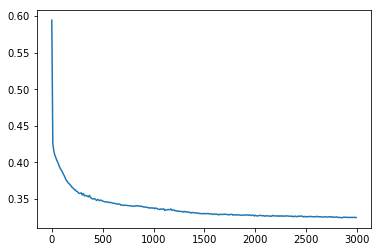

In [164]:
%matplotlib inline
print
if parameters['save_cost']:
    plt.plot(plot_data['epoch_list'], plot_data['cost_list'])

In [165]:
def evaluate(parameters, model):
    saver = tf.train.Saver()
    with tf.Session() as sess:
        init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        sess.run(init_op)
        saver.restore(sess, parameters['save_path'])
        print ("Train Accuracy:", model['accuracy'].eval({model['X']: X_train, 
                                                          model['y']: np.reshape(y_train, (X_train.shape[0], 1)) }))
        print ("Valid Accuracy:", model['accuracy'].eval({model['X']: X_test, 
                                                          model['y']: np.reshape(y_test, (X_test.shape[0], 1)) }))

In [174]:
with tf.Graph().as_default():
    model = create_model(parameters)
    evaluate(parameters, model)

INFO:tensorflow:Restoring parameters from C:/GitHub/kaggle/titanic/models/nn_clf
Train Accuracy: 0.8695652
Valid Accuracy: 0.83707863


In [117]:
def predict_nn(parameters, model):
    saver = tf.train.Saver()
    
    X_pred = parameters['X_pred']
    X_pred = preprocess_dataframe(X_pred, prediction_data=True, print_info=False)
    
    with tf.Session() as sess:
        init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        sess.run(init_op)
        saver.restore(sess, parameters['save_path'])
        prediction = model['prediction'].eval({model['X']: X_pred})
        return prediction.astype(int)

In [118]:
df_pred = parameters['PassangerId']

with tf.Graph().as_default():

    model = create_model(parameters)
    y_pred = predict_nn(parameters, model)
    df_pred['Survived'] = y_pred
    df_pred.to_csv('C:/GitHub/kaggle/titanic/predictions/predictions_neural_network.csv', sep=',', index=False)

df_pred.head(5)

INFO:tensorflow:Restoring parameters from C:/GitHub/kaggle/titanic/models/nn_clf


,PassengerId,Survived
0,892,0
1,893,0
2,894,1
3,895,1
4,896,0
